In [1]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rxr
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch


In [2]:
DATA_PATH = "/data/P-Prosjekter2/154012_monitoring_natural_habitat_loss_in_norway_with_cop/R/DATA/For_MSc/Project_1"
data_path = Path(DATA_PATH)

In [3]:
train_path_imgs = data_path / "new_train_val_scene" / "train"
train_path_masks = data_path / "new_train_val_truth" / "train"
val_path_imgs = data_path / "new_train_val_scene" / "val"
val_path_masks = data_path / "new_train_val_truth" / "val"

In [4]:
train_imgs = list((train_path_imgs).glob("*.tif"))
train_masks = list((train_path_masks).glob("*.tif"))

val_imgs = list((val_path_imgs).glob("*.tif"))
val_masks = list((val_path_masks).glob("*.tif"))

In [5]:
idx = 2
img = rxr.open_rasterio(train_imgs[idx])
mask = rxr.open_rasterio(train_masks[idx])

print("Image shape:", img.shape)
print("Min:", img.data.min(), "Max:", img.data.max())

Image shape: (30, 5011, 5004)
Min: 0 Max: 209290000


In [6]:
month_idx = 2  # Change this based on the desired month (0-4)
band_offset = month_idx * 6  # Since each month has 6 bands

blue_band = band_offset + 0
green_band = band_offset + 1
red_band = band_offset + 2

print("Selected bands:", red_band, green_band, blue_band)
print("Band values:\n", img.data[[red_band, green_band, blue_band]].shape)
print("Image shape:", img.shape)
print("Min:", img.data.min(), "Max:", img.data.max())
print("Red Band Min:", img.data[red_band].min(), "Max:", img.data[red_band].max())
print("Green Band Min:", img.data[green_band].min(), "Max:", img.data[green_band].max())
print("Blue Band Min:", img.data[blue_band].min(), "Max:", img.data[blue_band].max())


Selected bands: 14 13 12
Band values:
 (3, 5011, 5004)
Image shape: (30, 5011, 5004)
Min: 0 Max: 209290000
Red Band Min: 2200000 Max: 101485000
Green Band Min: 4090000 Max: 95600000
Blue Band Min: 6540000 Max: 94550000


In [7]:
rgb_img = img[[red_band, green_band, blue_band]].data

In [8]:
class_labels = ["urban", "cropland", "grass", "forest", "wetland", "water"]
class_colors = ["red", "yellow", "lime", "green", "purple", "blue"]

## Just dividing by 2000


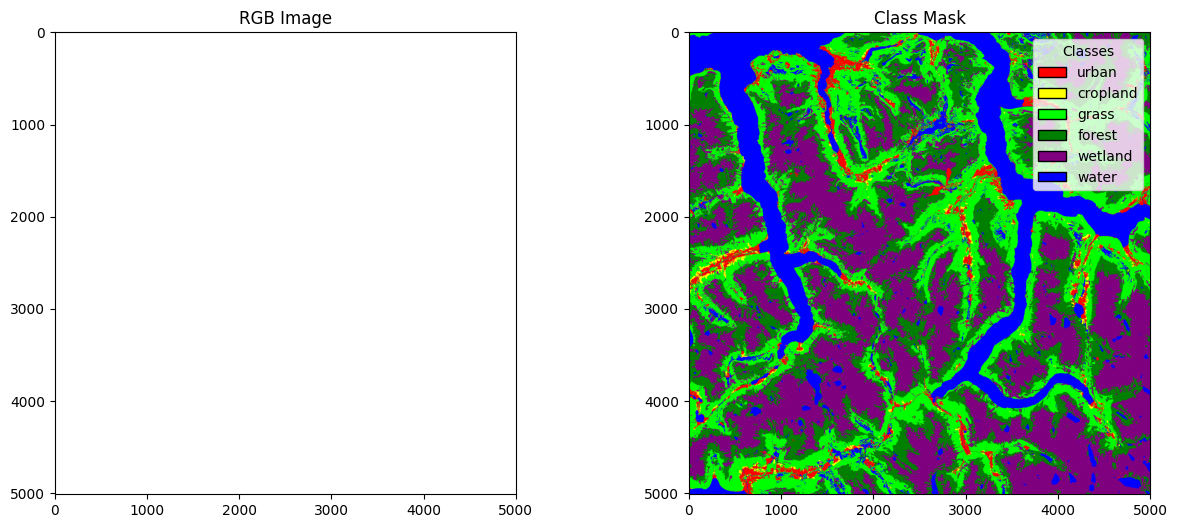

In [9]:
_, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot the RGB image
rgb_div = rgb_img.transpose((1, 2, 0)) / 2000
axs[0].imshow(rgb_div.clip(min=0, max=1))
axs[0].set_title("RGB Image")

# Plot the mask
axs[1].imshow(mask.data.squeeze(), cmap=ListedColormap(class_colors))
axs[1].set_title("Class Mask")

# Create a legend for the mask
legend_elements = [
    Patch(facecolor=color, edgecolor="black", label=label)
    for color, label in zip(class_colors, class_labels, strict=False)
]

axs[1].legend(handles=legend_elements, loc="upper right", title="Classes")

plt.show()

What the hell


## Normalize to [0,1]


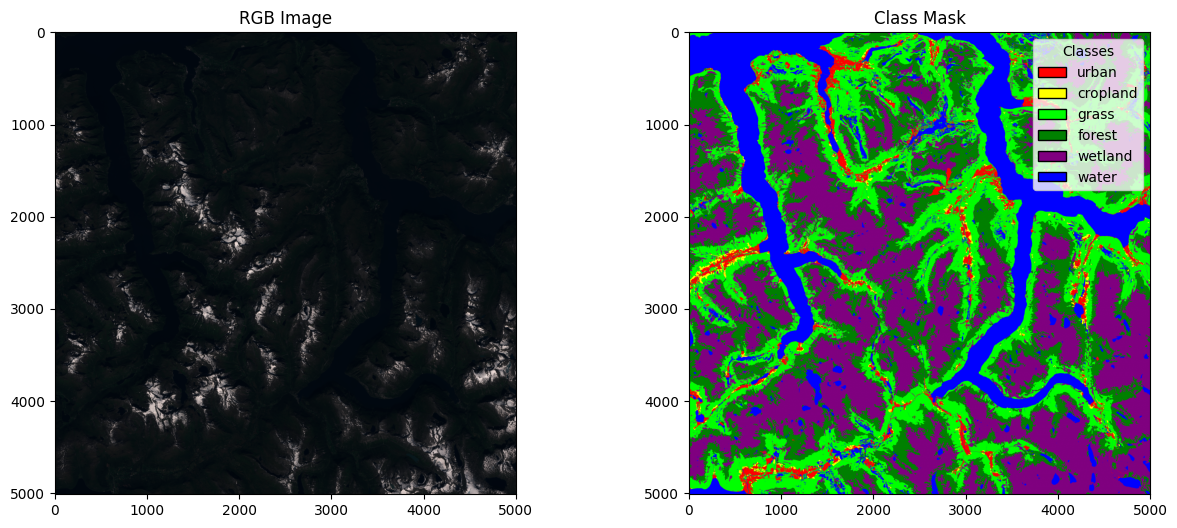

In [ ]:
_, axs = plt.subplots(1, 2, figsize=(15, 6))


def normalize_image(image):
    return (image - image.min()) / (image.max() - image.min()).clip(0, 1).transpose(
        1, 2, 0
    )


# Plot the RGB image
rgb_norm = normalize_image(rgb_img)
axs[0].imshow(rgb_norm)  # Ensure values are within [0,1]
axs[0].set_title("RGB Image")


# Plot the mask
axs[1].imshow(mask.data.squeeze(), cmap=ListedColormap(class_colors))
axs[1].set_title("Class Mask")

# Create a legend for the mask
legend_elements = [
    Patch(facecolor=color, edgecolor="black", label=label)
    for color, label in zip(class_colors, class_labels, strict=False)
]

axs[1].legend(handles=legend_elements, loc="upper right", title="Classes")

plt.show()


Still a bit too dark


## Precentile clipping


Okay this is better


The pixel values are extremely high (millions to hundreds of millions), which explains why your image appears too dark when divided by 2000 or even normalized to [0,1].


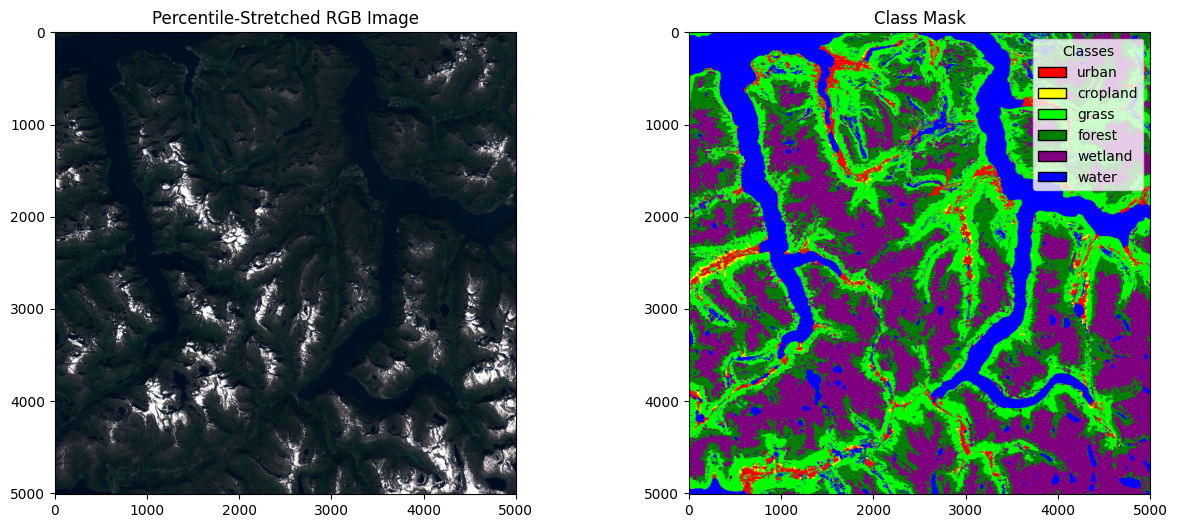

In [15]:

def normalize_percentile(img_array, percentiles=(2, 98)):
    """Normalize image using percentile clipping to enhance contrast."""
    min_val, max_val = np.percentile(img_array, percentiles)
    return np.clip((img_array - min_val) / (max_val - min_val), 0, 1)

_, axs = plt.subplots(1, 2, figsize=(15, 6))
rgb_img = img.data[[red_band, green_band, blue_band]].transpose((1, 2, 0))
rgb_norm_percentile = normalize_percentile(rgb_img)  # Apply normalization

# Display the corrected image
axs[0].imshow(rgb_norm_percentile)
axs[0].set_title("Percentile-Stretched RGB Image")

# Plot the mask
axs[1].imshow(mask.data.squeeze(), cmap=ListedColormap(class_colors))
axs[1].set_title("Class Mask")

# Create a legend for the mask
legend_elements = [
    Patch(facecolor=color, edgecolor="black", label=label)
    for color, label in zip(class_colors, class_labels, strict=False)
]

axs[1].legend(handles=legend_elements, loc="upper right", title="Classes")
plt.show()

## Histogram equalization


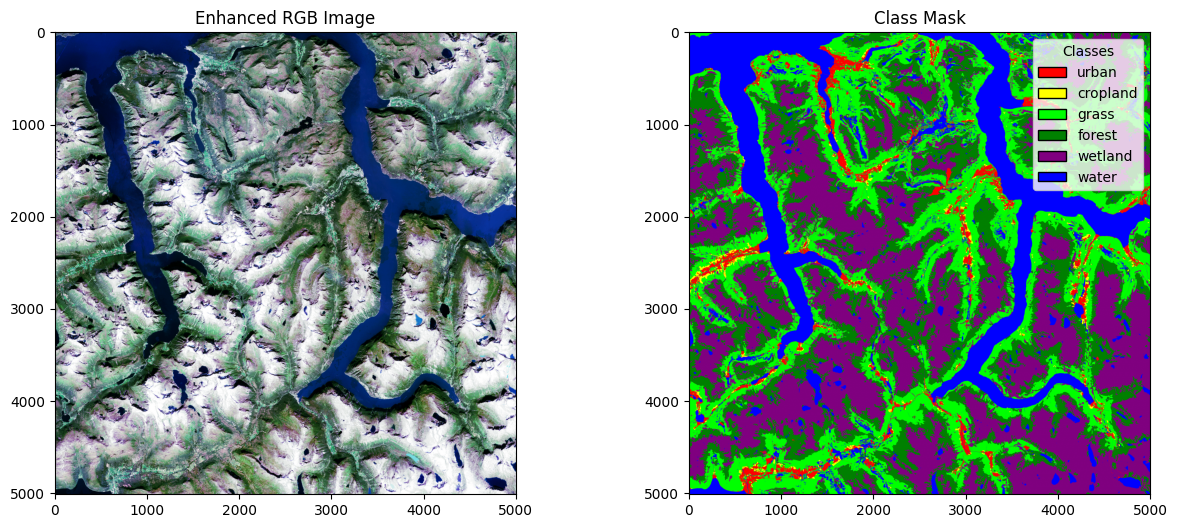

In [ ]:
_, axs = plt.subplots(1, 2, figsize=(15, 6))


def hist_equalization(image):
    """Apply histogram equalization on an image."""
    image = (image * 255).astype(np.uint8)  # Convert to uint8 for OpenCV
    for i in range(3):  # Apply to each channel separately
        image[..., i] = cv2.equalizeHist(image[..., i])
    return image / 255.0  # Scale back to [0,1]


# rgb_norm = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())
rgb_norm_percentile = normalize_image(rgb_img)  # Apply normalization
rgb_hist = hist_equalization(rgb_norm_percentile)
axs[0].imshow(rgb_hist)
axs[0].set_title("Enhanced RGB Image")


# Plot the mask
axs[1].imshow(mask.data.squeeze(), cmap=ListedColormap(class_colors))
axs[1].set_title("Class Mask")

# Create a legend for the mask
legend_elements = [
    Patch(facecolor=color, edgecolor="black", label=label)
    for color, label in zip(class_colors, class_labels, strict=False)
]

axs[1].legend(handles=legend_elements, loc="upper right", title="Classes")

plt.show()


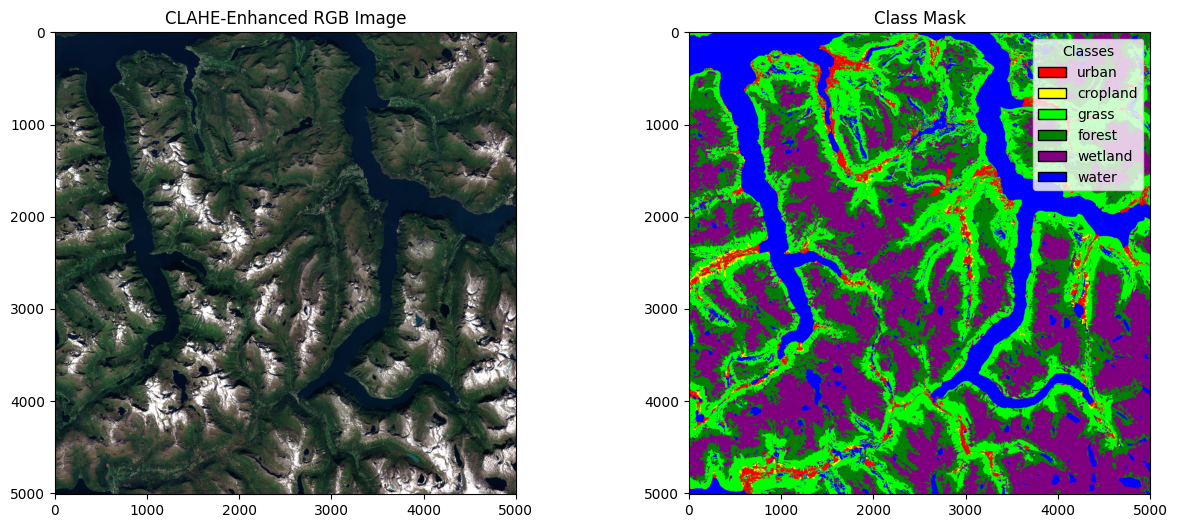

In [16]:
def adaptive_histogram_equalization(image):
    """Apply adaptive histogram equalization on each channel separately."""
    image = (image * 255).astype(np.uint8)  # Convert to uint8
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    for i in range(3):  # Apply CLAHE per channel
        image[..., i] = clahe.apply(image[..., i])

    return image / 255.0  # Scale back to [0,1]


_, axs = plt.subplots(1, 2, figsize=(15, 6))
rgb_norm = normalize_image(rgb_img)  # Apply normalization
rgb_adapt = adaptive_histogram_equalization(rgb_norm)
axs[0].imshow(rgb_adapt)
axs[0].set_title("CLAHE-Enhanced RGB Image")

# Plot the mask
axs[1].imshow(mask.data.squeeze(), cmap=ListedColormap(class_colors))
axs[1].set_title("Class Mask")

# Create a legend for the mask
legend_elements = [
    Patch(facecolor=color, edgecolor="black", label=label)
    for color, label in zip(class_colors, class_labels, strict=False)
]

axs[1].legend(handles=legend_elements, loc="upper right", title="Classes")

plt.show()


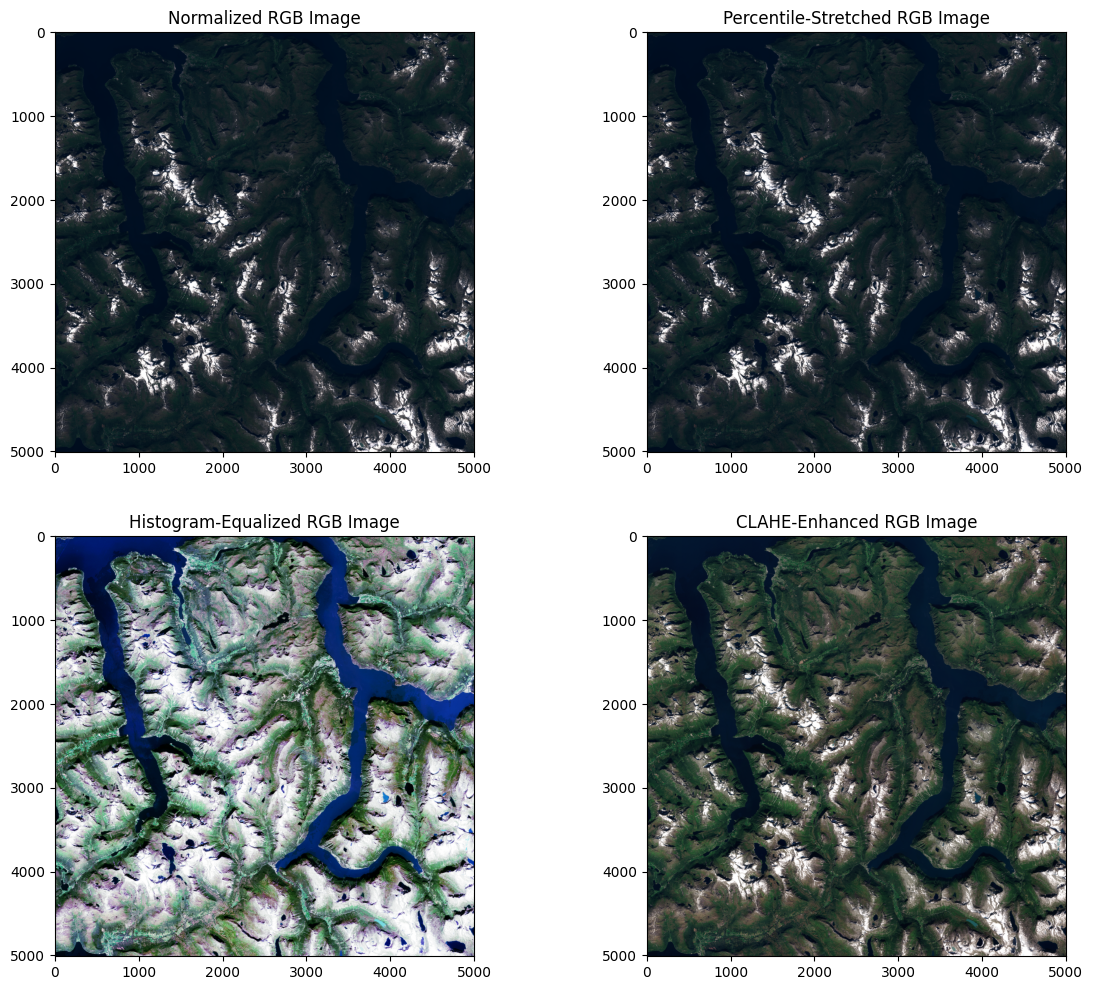

In [24]:
# plot all the different methods in one
_, axs = plt.subplots(2, 2, figsize=(14, 12))

# Original RGB image
axs[0, 0].imshow(normalize_image(rgb_img))
axs[0, 0].set_title("Normalized RGB Image")

# Percentile-Stretched RGB image
axs[0, 1].imshow(normalize_percentile(rgb_img))
axs[0, 1].set_title("Percentile-Stretched RGB Image")

# Histogram-Equalized RGB image
axs[1, 0].imshow(hist_equalization(normalize_image(rgb_img)))
axs[1, 0].set_title("Histogram-Equalized RGB Image")

# Adaptive Histogram-Equalized RGB image
axs[1, 1].imshow(adaptive_histogram_equalization(normalize_image(rgb_img)))
axs[1, 1].set_title("CLAHE-Enhanced RGB Image")

plt.show()